# REDES NUERONALES RECURRENTES

Implementacion con un set de sañales trigonometricas.

## Funciones comunes a todas la partes

In [1]:
# Librerias
import numpy as np
import matplotlib.pyplot as plt 
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error

In [3]:
# Funcion para generar base de datos de señales
def generate_time_series(batch_size, n_steps, n_future):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps + n_future)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps + n_future) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [4]:
# función que plotea un array de curvas (inputs y outputs)
def plot_series(series, y=None, y_pred=None, y_pred_std=None, x_label="$t$", y_label="$x$"):
  r, c = 3, 5
  fig, axes = plt.subplots(nrows=r, ncols=c, sharey=True, sharex=True, figsize=(20, 10))
  for row in range(r):
    for col in range(c):
        plt.sca(axes[row][col])
        ix = col + row*c
        plt.plot(series[ix, :], ".-")
        if y is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y[ix])), y[ix], "bx", markersize=10)
        if y_pred is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix], "ro")
        if y_pred_std is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] + y_pred_std[ix])
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] - y_pred_std[ix])
        plt.grid(True)
        plt.hlines(0, 0, 100, linewidth=1)
        plt.axis([0, len(series[ix, :])+len(y[ix]), -1, 1])
        if x_label and row == r - 1:
          plt.xlabel(x_label, fontsize=16)
        if y_label and col == 0:
          plt.ylabel(y_label, fontsize=16, rotation=0)
  plt.show()



In [5]:
# Clase dataset para luego armar los dataloader
class TimeSeriesDataset(Dataset):
  def __init__(self, X, y=None, train=True):
    self.X = X
    self.y = y
    self.train = train

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    if self.train:
      return torch.from_numpy(self.X[ix]), torch.from_numpy(self.y[ix])
    return torch.from_numpy(self.X[ix]) # si no es train, solo devuelve el X


In [6]:
# funciones de entrenamiento

from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, dataloader, epochs=5):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.MSELoss()

    for epoch in range(epochs+1):
        print("epoch numero: ", epoch)
        bar = tqdm(dataloader['train'])
        model.train()
        train_loss = []
        eval_loss = []
        for batch in bar:
            X, y = batch
            #print(X.shape)
            #input()
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)

            #print('y shape')
            #print(y.shape)
            y = y.view(y.shape[0], -1) # aca elimino la dim de la profundidad
            #print(y.shape)
            #print(' y hat shape')
            #print(y_hat.shape)
            
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            bar.set_description(f"train_loss {np.mean(train_loss):.5f}")
        
        bar = tqdm(dataloader['eval'])
        model.eval()
        
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                y = y.view(y.shape[0], -1)
                loss = criterion(y_hat, y)
                eval_loss.append(loss.item())
                bar.set_description(f"valid_loss {np.mean(eval_loss):.5f}")
        
def predict(model, dataloader):
    model.eval()
    with torch.no_grad():
        preds = torch.tensor([]).to(device)
        for batch in dataloader:
            X = batch
            X = X.to(device)
            pred = model(X)
            preds = torch.cat([preds, pred])
        return preds

In [7]:
# función para imprimir parametros del modelo.
def imp_param(model):
  print('-'*84)
  print('PARAMETROS DEL MODELO')
  print('-'*84)
  for name, param in model.named_parameters():
    if param.requires_grad: 
      print('Nombre del parámetro: ')
      print(name)
      print('Tamaño del parámetro: ')
      print(param.data.shape)
      print()

## Primera aproximación de recurrencia, empleado un perceptrón multicapa.
(adapación de un MLP para predecir el valor futuro de un señal)



In [42]:
n_steps = 50
n_future = 1
series = generate_time_series(10000, n_steps, n_future)
X_train, y_train = series[:7000, :n_steps], series[:7000, -n_future:]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -n_future:]
X_test, y_test = series[9000:, :n_steps], series[9000:, -n_future:]
print('X and y Train shape')
print(X_train.shape, y_train.shape)

print('X and y Valid shape')
print(X_valid.shape, y_valid.shape)

print('X and y Test shape')
print(X_test.shape, y_test.shape)

X and y Train shape
(7000, 50, 1) (7000, 1, 1)
X and y Valid shape
(2000, 50, 1) (2000, 1, 1)
X and y Test shape
(1000, 50, 1) (1000, 1, 1)


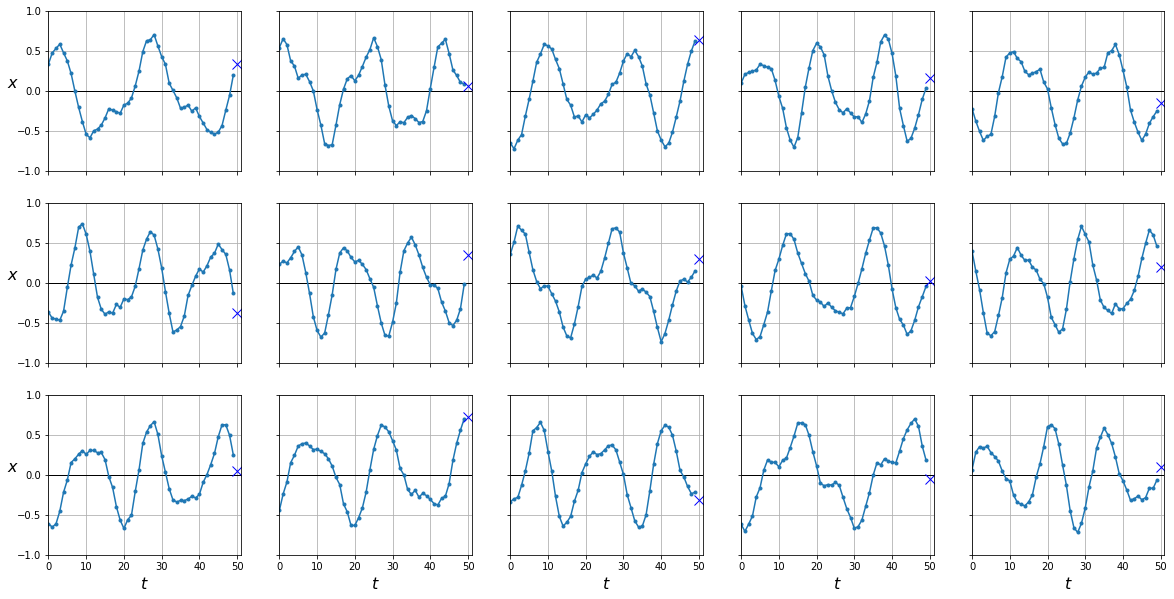

In [10]:
plot_series(X_test, y_test)

In [43]:
dataset = {
    'train': TimeSeriesDataset(X_train, y_train),
    'eval': TimeSeriesDataset(X_valid, y_valid),
    'test': TimeSeriesDataset(X_test, y_test, train=False)
}

dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}

MLP para comparar luego con RNN

In [51]:
class MLP(torch.nn.Module):
  def __init__(self, n_in=n_steps, n_out=n_future):
    super().__init__()
    self.fc = torch.nn.Linear(n_in, n_out)

  def forward(self, x):
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x

# n_steps y out_future definidos arriba
mlp = MLP(n_steps, n_future)
mlp

MLP(
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [52]:
fit(mlp, dataloader)

epoch numero:  0


valid_loss 0.07434: 100%|██████████| 32/32 [00:00<00:00, 388.16it/s]


epoch numero:  1


valid_loss 0.04621: 100%|██████████| 32/32 [00:00<00:00, 332.51it/s]


epoch numero:  2


valid_loss 0.03249: 100%|██████████| 32/32 [00:00<00:00, 338.15it/s]


epoch numero:  3


valid_loss 0.02405: 100%|██████████| 32/32 [00:00<00:00, 304.04it/s]


epoch numero:  4


valid_loss 0.01885: 100%|██████████| 32/32 [00:00<00:00, 293.81it/s]


epoch numero:  5


valid_loss 0.01556: 100%|██████████| 32/32 [00:00<00:00, 242.82it/s]


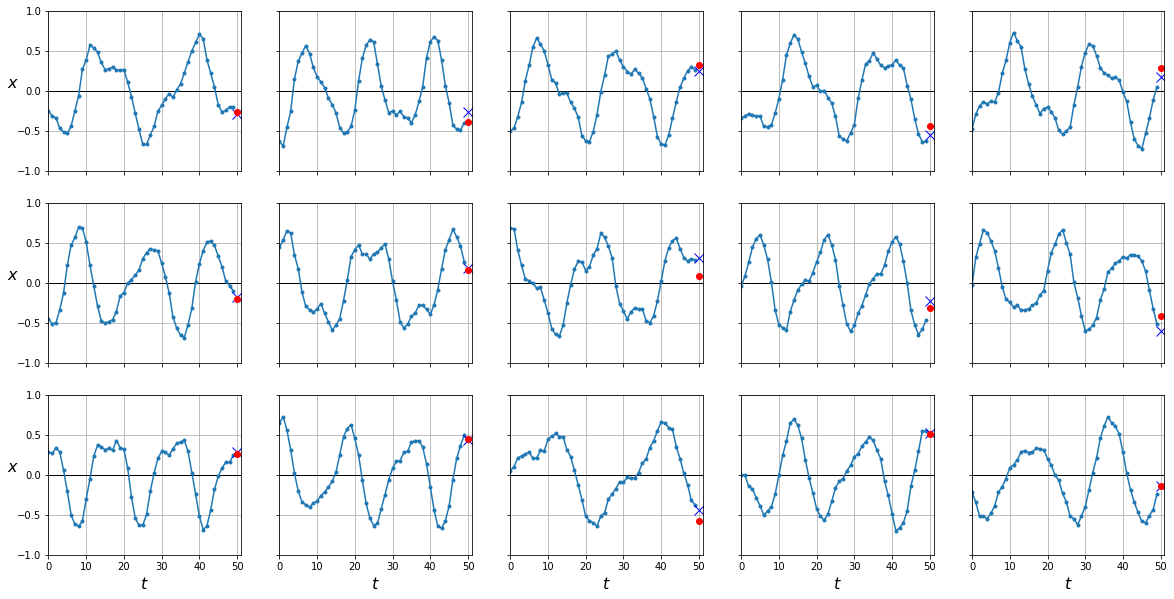

y_test shape:
(1000, 1, 1)
y_pred shape:
torch.Size([1000, 1])
Error cuadratico medio de la estimación final: 


0.016778043

In [54]:
y_pred = predict(mlp, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())

print('y_test shape:')
print(y_test.shape)
print('y_pred shape:')
print(y_pred.shape)
print('Error cuadratico medio de la estimación final: ')
mean_squared_error(np.squeeze(y_test), y_pred)

## Veamos ahora una RNN básica de 1 sola neurona

In [55]:
class SimpleRNN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=1, num_layers=1, batch_first=True)

  def forward(self, x):
    x, h = self.rnn(x) 
    # solo queremos la última salidas
    #return x[:,-10:]
    return x[:,-1:,-1]

rnn = SimpleRNN()
rnn

SimpleRNN(
  (rnn): RNN(1, 1, batch_first=True)
)

In [56]:
# veamos que arroja nuestra rnn

entrada = torch.rand(50)
print('entrada')
print(entrada)
# le agrego las dimensiones necesarias
entrada = entrada[None, :, None]
print('entrada con nuevas dimensiones')
print('[batch, Length, nr_features] ')
entrada.shape

entrada
tensor([0.9197, 0.6830, 0.5987, 0.5407, 0.0572, 0.4425, 0.1747, 0.5821, 0.3818,
        0.1489, 0.0393, 0.8137, 0.1902, 0.7362, 0.5259, 0.3823, 0.4422, 0.6039,
        0.9983, 0.1427, 0.2162, 0.3042, 0.9944, 0.2673, 0.9621, 0.1650, 0.9820,
        0.1229, 0.2270, 0.6608, 0.8569, 0.6606, 0.1957, 0.5588, 0.5567, 0.9171,
        0.3183, 0.6128, 0.9508, 0.5050, 0.5666, 0.1513, 0.0941, 0.0759, 0.7312,
        0.8205, 0.1666, 0.6548, 0.2251, 0.4527])
entrada con nuevas dimensiones
[batch, Length, nr_features] 


torch.Size([1, 50, 1])

In [57]:
# paso la entrada a la red
salida = rnn(entrada)

print('salida de la red (largo igual al input):')
print(salida)

print('salida shape:')
print(salida.shape)

salida de la red (largo igual al input):
tensor([[-0.7787]], grad_fn=<SelectBackward0>)
salida shape:
torch.Size([1, 1])


In [ ]:
# ahora el vamos a pasar un set del dataset...

In [58]:

# veo primero una muestra del dataloader

xs, ys = next(iter(dataloader['train']))
print('tamaño del xs que le paso como input:')
print('batch x largo x nro features (si paso mas de 1 feature por tiempo)')
print(xs.shape)
print('---------')
print('tamaño del ys que le paso como input:')
print('batch x largo x nro features(si paso mas de 1 feature por tiempo)')
print(ys.shape)

tamaño del xs que le paso como input:
batch x largo x nro features (si paso mas de 1 feature por tiempo)
torch.Size([64, 50, 1])
---------
tamaño del ys que le paso como input:
batch x largo x nro features(si paso mas de 1 feature por tiempo)
torch.Size([64, 1, 1])


In [59]:
nr = 0
serie = xs[nr]
deseado = ys[nr]
print('input shape:')
print(serie.shape)
salida = rnn(serie[None,:])
print('salida de la red (largo igual al input):')
print(salida.shape)
print('tamaño del valor deseado:')
print(deseado.shape)


input shape:
torch.Size([50, 1])
salida de la red (largo igual al input):
torch.Size([1, 1])
tamaño del valor deseado:
torch.Size([1, 1])


In [60]:
fit(rnn, dataloader)

epoch numero:  0


valid_loss 0.58399: 100%|██████████| 32/32 [00:00<00:00, 162.56it/s]


epoch numero:  1


valid_loss 0.46633: 100%|██████████| 32/32 [00:00<00:00, 164.88it/s]


epoch numero:  2


valid_loss 0.38884: 100%|██████████| 32/32 [00:00<00:00, 144.55it/s]


epoch numero:  3


valid_loss 0.32760: 100%|██████████| 32/32 [00:00<00:00, 163.42it/s]


epoch numero:  4


valid_loss 0.27932: 100%|██████████| 32/32 [00:00<00:00, 164.58it/s]


epoch numero:  5


valid_loss 0.24104: 100%|██████████| 32/32 [00:00<00:00, 176.03it/s]


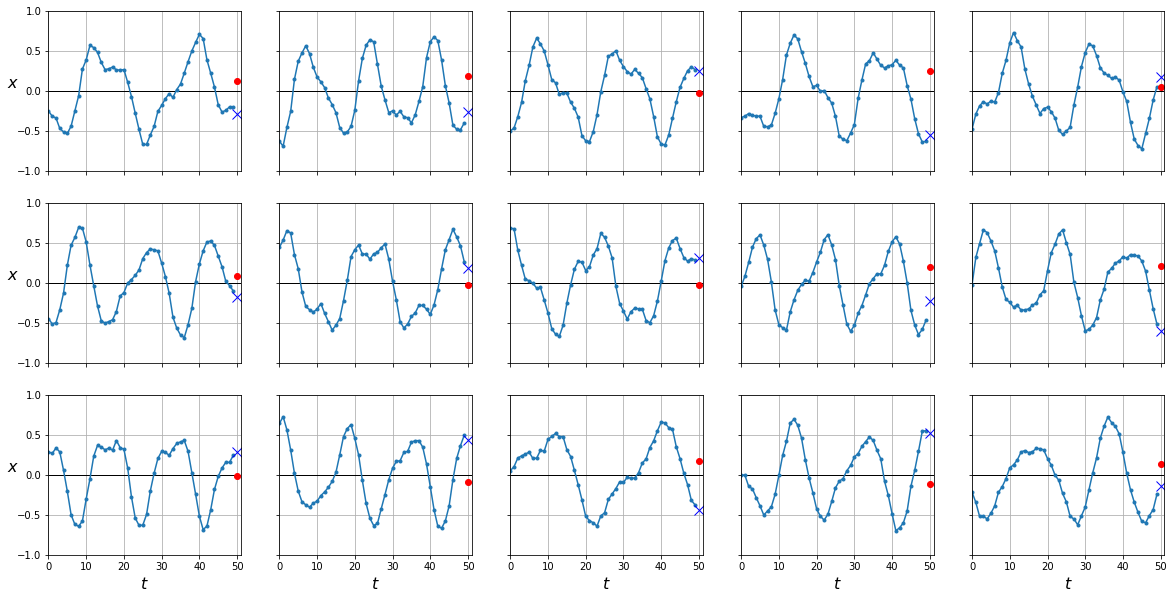

y_test shape:
(1000, 1, 1)
y_pred shape:
torch.Size([1000, 1])
Error cuadratico medio de la estimación final: 


0.24079233

In [61]:
y_pred = predict(rnn, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())


print('y_test shape:')
print(y_test.shape)
print('y_pred shape:')
print(y_pred.shape)
print('Error cuadratico medio de la estimación final: ')
mean_squared_error(np.squeeze(y_test), np.squeeze(y_pred))

## Comparacion de parámetros entre MLP y RNN implementada

In [62]:
# parámetros en el MLP

imp_param(mlp)

------------------------------------------------------------------------------------
PARAMETROS DEL MODELO
------------------------------------------------------------------------------------
Nombre del parámetro: 
fc.weight
Tamaño del parámetro: 
torch.Size([1, 50])

Nombre del parámetro: 
fc.bias
Tamaño del parámetro: 
torch.Size([1])



In [63]:
# parámetros en el RNN

imp_param(rnn)

------------------------------------------------------------------------------------
PARAMETROS DEL MODELO
------------------------------------------------------------------------------------
Nombre del parámetro: 
rnn.weight_ih_l0
Tamaño del parámetro: 
torch.Size([1, 1])

Nombre del parámetro: 
rnn.weight_hh_l0
Tamaño del parámetro: 
torch.Size([1, 1])

Nombre del parámetro: 
rnn.bias_ih_l0
Tamaño del parámetro: 
torch.Size([1])

Nombre del parámetro: 
rnn.bias_hh_l0
Tamaño del parámetro: 
torch.Size([1])



## Incorporamos más neuronas en la RNN

In [65]:
import torchsummary

In [79]:
class RNN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=20, num_layers=1, batch_first=True)
    self.fc = torch.nn.Linear(20, 1)

  def forward(self, x):
    x, h = self.rnn(x) 
    # get the last output and apply linear layer
    #print('x shape')
    # print(x.shape)
    #print('x shape [:,-1:]')
    # print(x[:,-1].shape)
    y = self.fc(x[:,-1])
    
    return y

rnn_2 = RNN()

In [80]:
torchsummary.summary(rnn_2, input_size=(50, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               RNN-1  [[-1, 50, 20], [-1, 2, 20]]               0
            Linear-2                    [-1, 1]              21
Total params: 21
Trainable params: 21
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.31
Params size (MB): 0.00
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


In [75]:
# parámetros en el RNN

imp_param(rnn_2)

------------------------------------------------------------------------------------
PARAMETROS DEL MODELO
------------------------------------------------------------------------------------
Nombre del parámetro: 
rnn.weight_ih_l0
Tamaño del parámetro: 
torch.Size([20, 1])

Nombre del parámetro: 
rnn.weight_hh_l0
Tamaño del parámetro: 
torch.Size([20, 20])

Nombre del parámetro: 
rnn.bias_ih_l0
Tamaño del parámetro: 
torch.Size([20])

Nombre del parámetro: 
rnn.bias_hh_l0
Tamaño del parámetro: 
torch.Size([20])

Nombre del parámetro: 
fc.weight
Tamaño del parámetro: 
torch.Size([1, 20])

Nombre del parámetro: 
fc.bias
Tamaño del parámetro: 
torch.Size([1])



In [76]:
# veamos que arroja nuestra rnn_2

entrada = torch.rand(20)
print('entrada')
print(entrada)
# le agrego las dimensiones necesarias
entrada = entrada[None, :, None]
print('entrada con nuevas dimensiones')
print('[batch, Length, nr_features] ')
entrada.shape

entrada
tensor([0.3676, 0.7858, 0.3285, 0.1991, 0.3576, 0.2869, 0.9712, 0.1923, 0.6540,
        0.1405, 0.0679, 0.2840, 0.2140, 0.4430, 0.8893, 0.4086, 0.4342, 0.8478,
        0.4456, 0.1019])
entrada con nuevas dimensiones
[batch, Length, nr_features] 


torch.Size([1, 20, 1])

In [77]:
# paso la entrada a la red
salida = rnn_2(entrada)

print('salida de la red (largo igual al input):')
print(salida)
print('salida shape:')
print(salida.shape)

torch.Size([1, 20, 20])
torch.Size([1, 20])
salida de la red (largo igual al input):
tensor([[-0.1983]], grad_fn=<AddmmBackward0>)
salida shape:
torch.Size([1, 1])


In [81]:
fit(rnn_2, dataloader)

epoch numero:  0


valid_loss 0.02703: 100%|██████████| 32/32 [00:00<00:00, 178.31it/s]


epoch numero:  1


valid_loss 0.00959: 100%|██████████| 32/32 [00:00<00:00, 154.84it/s]


epoch numero:  2


valid_loss 0.00576: 100%|██████████| 32/32 [00:00<00:00, 170.82it/s]


epoch numero:  3


valid_loss 0.00521: 100%|██████████| 32/32 [00:00<00:00, 183.62it/s]


epoch numero:  4


valid_loss 0.00451: 100%|██████████| 32/32 [00:00<00:00, 176.59it/s]


epoch numero:  5


valid_loss 0.00426: 100%|██████████| 32/32 [00:00<00:00, 173.36it/s]


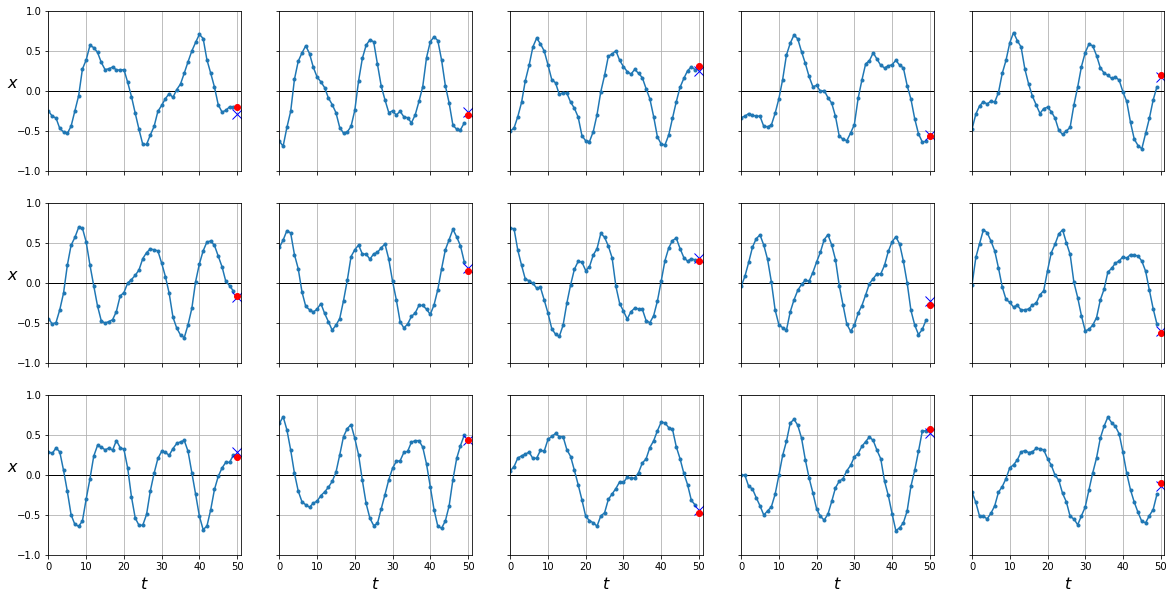

y_test shape:
(1000, 1, 1)
y_pred shape:
torch.Size([1000, 1])
Error cuadratico medio de la estimación final: 


0.0043357518

In [82]:
y_pred = predict(rnn_2, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())


y_testb = np.squeeze(y_test)
print('y_test shape:')
print(y_test.shape)
print('y_pred shape:')
print(y_pred.shape)
print('Error cuadratico medio de la estimación final: ')
mean_squared_error(np.squeeze(y_test), y_pred.cpu())

## Le agregamos 1 layer mas, para tener mas profundidad





In [83]:
class DeepRNN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=20, num_layers=2, batch_first=True)
    self.fc = torch.nn.Linear(20, 1)

  def forward(self, x):
    x, h = self.rnn(x) 
    x = self.fc(x[:,-1])
    return x

In [84]:
rnn_deep = DeepRNN()
fit(rnn_deep, dataloader)

epoch numero:  0


valid_loss 0.01296: 100%|██████████| 32/32 [00:00<00:00, 129.22it/s]


epoch numero:  1


valid_loss 0.00524: 100%|██████████| 32/32 [00:00<00:00, 137.59it/s]


epoch numero:  2


valid_loss 0.00427: 100%|██████████| 32/32 [00:00<00:00, 152.51it/s]


epoch numero:  3


valid_loss 0.00371: 100%|██████████| 32/32 [00:00<00:00, 147.04it/s]


epoch numero:  4


valid_loss 0.00362: 100%|██████████| 32/32 [00:00<00:00, 145.61it/s]


epoch numero:  5


valid_loss 0.00355: 100%|██████████| 32/32 [00:00<00:00, 138.09it/s]


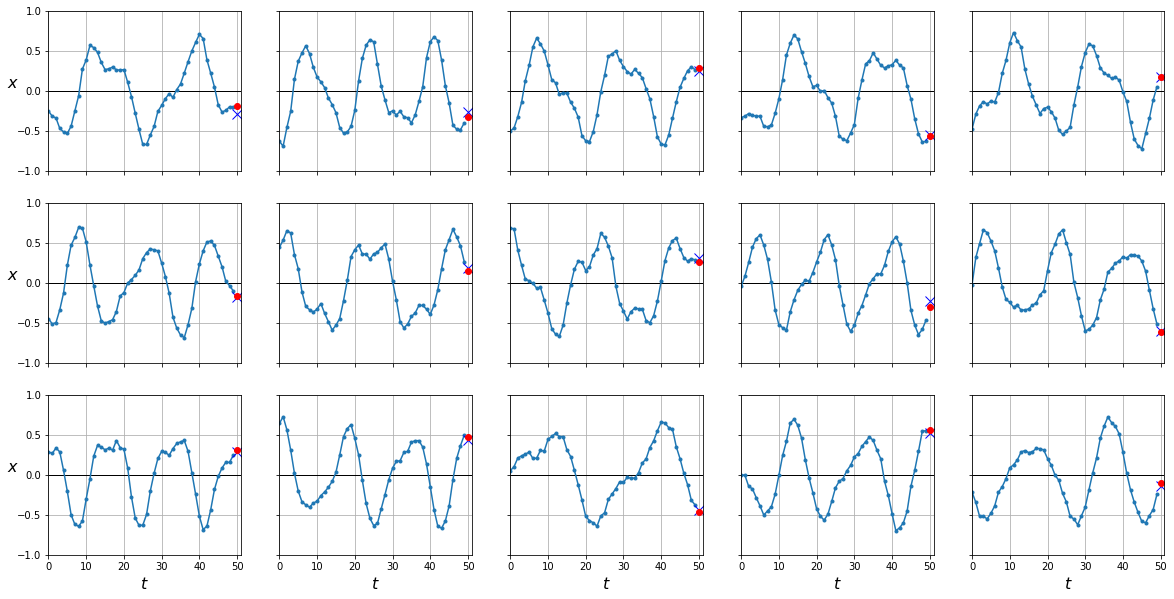

y_test shape:
(1000, 1, 1)
y_pred shape:
torch.Size([1000, 1])
Error cuadratico medio de la estimación final: 


0.0036587077

In [85]:
y_pred = predict(rnn_deep, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())

y_testb = np.squeeze(y_test)
print('y_test shape:')
print(y_test.shape)
print('y_pred shape:')
print(y_pred.shape)
print('Error cuadratico medio de la estimación final: ')
mean_squared_error(np.squeeze(y_test), np.squeeze(y_pred))

In [86]:
# parámetros en el RNN

imp_param(rnn_deep)

------------------------------------------------------------------------------------
PARAMETROS DEL MODELO
------------------------------------------------------------------------------------
Nombre del parámetro: 
rnn.weight_ih_l0
Tamaño del parámetro: 
torch.Size([20, 1])

Nombre del parámetro: 
rnn.weight_hh_l0
Tamaño del parámetro: 
torch.Size([20, 20])

Nombre del parámetro: 
rnn.bias_ih_l0
Tamaño del parámetro: 
torch.Size([20])

Nombre del parámetro: 
rnn.bias_hh_l0
Tamaño del parámetro: 
torch.Size([20])

Nombre del parámetro: 
rnn.weight_ih_l1
Tamaño del parámetro: 
torch.Size([20, 20])

Nombre del parámetro: 
rnn.weight_hh_l1
Tamaño del parámetro: 
torch.Size([20, 20])

Nombre del parámetro: 
rnn.bias_ih_l1
Tamaño del parámetro: 
torch.Size([20])

Nombre del parámetro: 
rnn.bias_hh_l1
Tamaño del parámetro: 
torch.Size([20])

Nombre del parámetro: 
fc.weight
Tamaño del parámetro: 
torch.Size([1, 20])

Nombre del parámetro: 
fc.bias
Tamaño del parámetro: 
torch.Size([1])



# predecimos 10 valores a futuro, colocando la última predicción en la entrada, hasta llegar a 10 pasos iterativos

series shape
(10000, 60, 1)
X and y Train shape
(7000, 50, 1) (7000, 10, 1)
X and y Valid shape
(2000, 50, 1) (2000, 10, 1)
X and y Test shape
(1000, 50, 1) (1000, 10, 1)


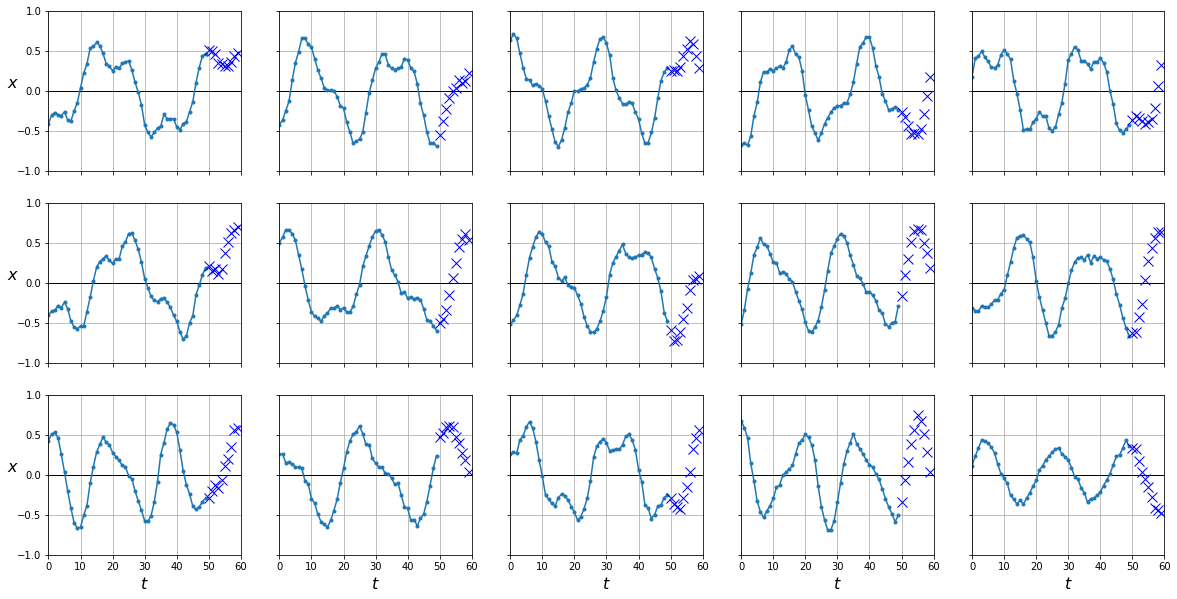

(1000, 10, 1)
(1000, 1, 1)


In [94]:
# generamos unos nuevos datos para tener con qué comparar

n_steps = 50
n_future = 10

series = generate_time_series(10000, n_steps, n_future)
print('series shape')
print(series.shape)

X_train, y_train = series[:7000, :n_steps], series[:7000, -n_future:]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -n_future:]
X_test, y_test = series[9000:, :n_steps], series[9000:, -n_future:]
print('X and y Train shape')
print(X_train.shape, y_train.shape)

print('X and y Valid shape')
print(X_valid.shape, y_valid.shape)

print('X and y Test shape')
print(X_test.shape, y_test.shape)

# ploteamos
plot_series(X_test, y_test)
print(y_test.shape)
print(y_test[:,:1,:].shape)

In [95]:
#  tenemos q armar un nuevo dataloader que pase 1 solo valor a futuro
# pero tengamos los siguientes 9 para ver el error de nuestra propia iteración
dataset = {
    'train': TimeSeriesDataset(X_train, y_train[:,:1,:]),
    'eval': TimeSeriesDataset(X_valid, y_valid[:,:1,:]),
    'test': TimeSeriesDataset(X_test, y_test[:,:1,:], train=False)
}

dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}
print(type(dataloader))


<class 'dict'>


In [96]:
# veo primero una muestra del dataloader

xs, ys = next(iter(dataloader['train']))
print('tamaño del xs que le paso como input:')
print('batch x largo x nro features (si paso mas de 1 feature por tiempo)')
print(xs.shape)
print('---------')
print('tamaño del ys que le paso como output:')
print('batch x largo x nro features(si paso mas de 1 feature por tiempo)')
print(ys.shape)

tamaño del xs que le paso como input:
batch x largo x nro features (si paso mas de 1 feature por tiempo)
torch.Size([64, 50, 1])
---------
tamaño del ys que le paso como output:
batch x largo x nro features(si paso mas de 1 feature por tiempo)
torch.Size([64, 1, 1])


In [97]:
# entreno de nueva la ultima red y graficamos
rnn_deep = DeepRNN()
fit(rnn_deep, dataloader)


epoch numero:  0


valid_loss 0.01082: 100%|██████████| 32/32 [00:00<00:00, 139.47it/s]


epoch numero:  1


valid_loss 0.00660: 100%|██████████| 32/32 [00:00<00:00, 153.30it/s]


epoch numero:  2


valid_loss 0.00520: 100%|██████████| 32/32 [00:00<00:00, 155.37it/s]


epoch numero:  3


valid_loss 0.00401: 100%|██████████| 32/32 [00:00<00:00, 146.10it/s]


epoch numero:  4


valid_loss 0.00358: 100%|██████████| 32/32 [00:00<00:00, 119.06it/s]


epoch numero:  5


valid_loss 0.00369: 100%|██████████| 32/32 [00:00<00:00, 140.85it/s]


In [98]:
print(xs.shape)
#predict(rnn_deep, xs)
sal = rnn_deep(xs)
sal.shape

torch.Size([64, 50, 1])


torch.Size([64, 1])

(1000, 10)


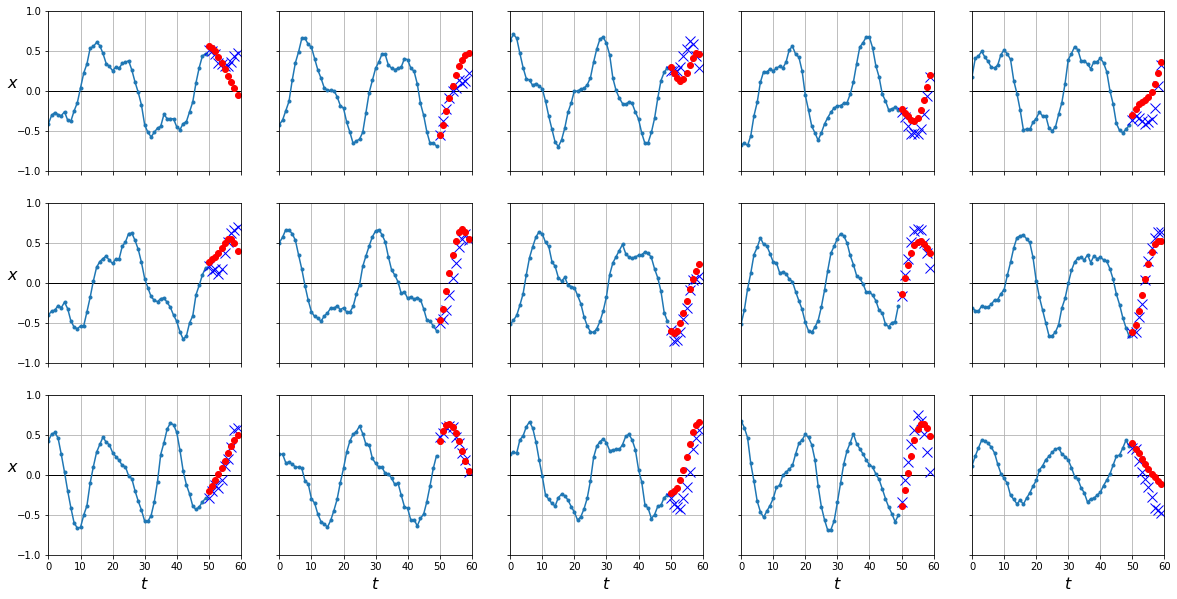

(1000, 10, 1)
(1000, 10)


0.038010858

In [99]:
# graficamos

X = X_test
for step_ahead in range(10):
    #print(step_ahead)
    inputs = torch.from_numpy(X[:, step_ahead:]).unsqueeze(0) # para el predict lea bien los datos (de este modo lee batch x largo x prof)
    #print(inputs.shape)
    y_pred_one = predict(rnn_deep, inputs).cpu().numpy()
    #print(y_pred_one.shape)
    X = np.concatenate([X, y_pred_one[:, np.newaxis, :]], axis=1)
    #print(X.shape)

y_pred = X[:, n_steps:, -1]
print(y_pred.shape)
plot_series(X_test, y_test, y_pred)
print(y_test.shape)
print(y_pred.shape)
mean_squared_error(np.squeeze(y_test), y_pred)

epoch numero:  0


valid_loss 0.01102: 100%|██████████| 32/32 [00:00<00:00, 333.18it/s]


epoch numero:  1


valid_loss 0.00780: 100%|██████████| 32/32 [00:00<00:00, 240.63it/s]


epoch numero:  2


valid_loss 0.00597: 100%|██████████| 32/32 [00:00<00:00, 239.91it/s]


epoch numero:  3


valid_loss 0.00481: 100%|██████████| 32/32 [00:00<00:00, 197.92it/s]


epoch numero:  4


valid_loss 0.00415: 100%|██████████| 32/32 [00:00<00:00, 221.44it/s]


epoch numero:  5


valid_loss 0.00379: 100%|██████████| 32/32 [00:00<00:00, 243.12it/s]


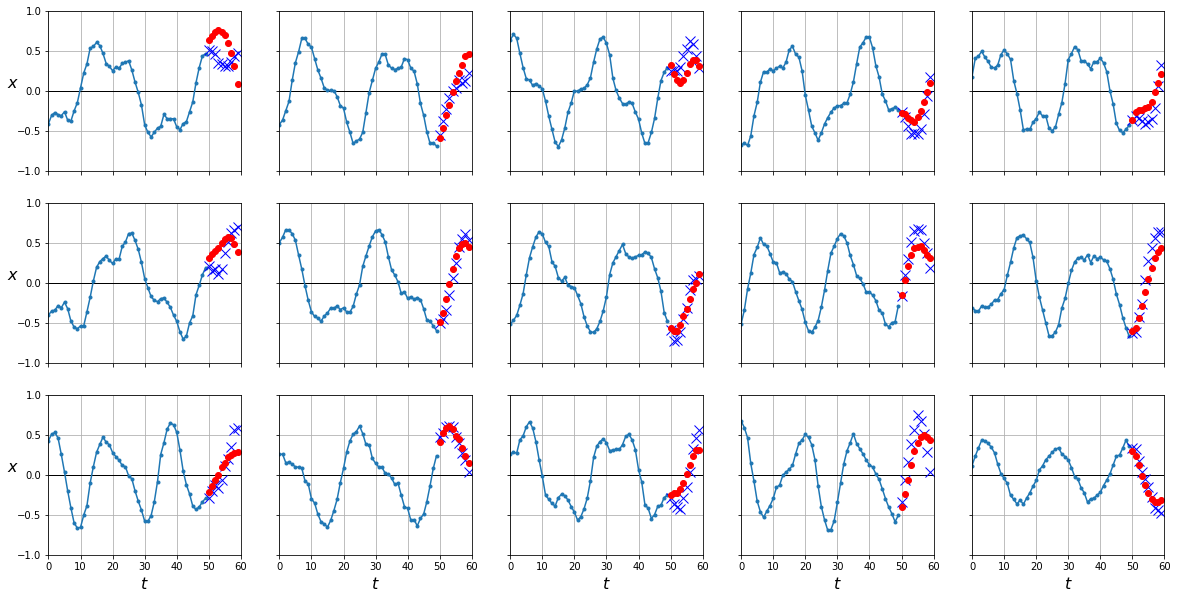

(1000, 10, 1)
(1000, 10)


0.021347923

In [100]:
# lo comparamos en el mlp
# entreno de nuevo el mlp con los nuevos datos y graficamos

fit(mlp, dataloader)

X = X_test
for step_ahead in range(10):
    inputs = torch.from_numpy(X[:, step_ahead:]).unsqueeze(0)  # para el predict lea bien los datos (de este modo lee batch x largo x prof)
    y_pred_one = predict(mlp, inputs).cpu().numpy()
    X = np.concatenate([X, y_pred_one[:, np.newaxis, :]], axis=1)

y_pred = X[:, n_steps:, -1]
plot_series(X_test, y_test, y_pred)
print(y_test.shape)
print(y_pred.shape)
mean_squared_error(np.squeeze(y_test), y_pred)


# TP

## Crear una RNN que tenga 10 salidas y mejore el error del MLP usado antes. Asegurarse de compararlos con el mismo set datos!!

In [101]:
#  dataloader para predecir los 10 del futuro en un solo paso
dataset = {
    'train': TimeSeriesDataset(X_train, y_train),
    'eval': TimeSeriesDataset(X_valid, y_valid),
    'test': TimeSeriesDataset(X_test, y_test, train=False)
}

dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}
print(type(dataloader))



<class 'dict'>


In [107]:
# veo primero una muestra del dataloader

xs, ys = next(iter(dataloader['train']))
print('tamaño del xs que le paso como input:')
print('batch x largo x nro features (si paso mas de 1 feature por tiempo)')
print(xs.shape)
print('---------')
print('tamaño del ys que le paso como output:')
print('batch x largo x nro features(si paso mas de 1 feature por tiempo)')
print(ys.shape)

tamaño del xs que le paso como input:
batch x largo x nro features (si paso mas de 1 feature por tiempo)
torch.Size([64, 50, 1])
---------
tamaño del ys que le paso como output:
batch x largo x nro features(si paso mas de 1 feature por tiempo)
torch.Size([64, 10, 1])


In [149]:
class DeepRNN_2(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=25, num_layers=4, batch_first=True)
    self.fc = torch.nn.Linear(25, 10)

  def forward(self, x):
    x, h = self.rnn(x) 
    x = self.fc(x[:,-1])
    return x

In [150]:
rnn_deep2 = DeepRNN_2()

In [151]:
torchsummary.summary(rnn_deep2, input_size=(50, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               RNN-1  [[-1, 50, 25], [-1, 2, 25]]               0
            Linear-2                   [-1, 10]             260
Total params: 260
Trainable params: 260
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.48
Params size (MB): 0.00
Estimated Total Size (MB): 0.48
----------------------------------------------------------------


In [152]:
fit(rnn_deep2, dataloader)

epoch numero:  0


valid_loss 0.04139: 100%|██████████| 32/32 [00:00<00:00, 83.35it/s]


epoch numero:  1


valid_loss 0.03119: 100%|██████████| 32/32 [00:00<00:00, 83.48it/s]


epoch numero:  2


valid_loss 0.03120: 100%|██████████| 32/32 [00:00<00:00, 78.09it/s]


epoch numero:  3


valid_loss 0.01729: 100%|██████████| 32/32 [00:00<00:00, 74.34it/s]


epoch numero:  4


valid_loss 0.01551: 100%|██████████| 32/32 [00:00<00:00, 84.52it/s]


epoch numero:  5


valid_loss 0.01375: 100%|██████████| 32/32 [00:00<00:00, 80.72it/s]


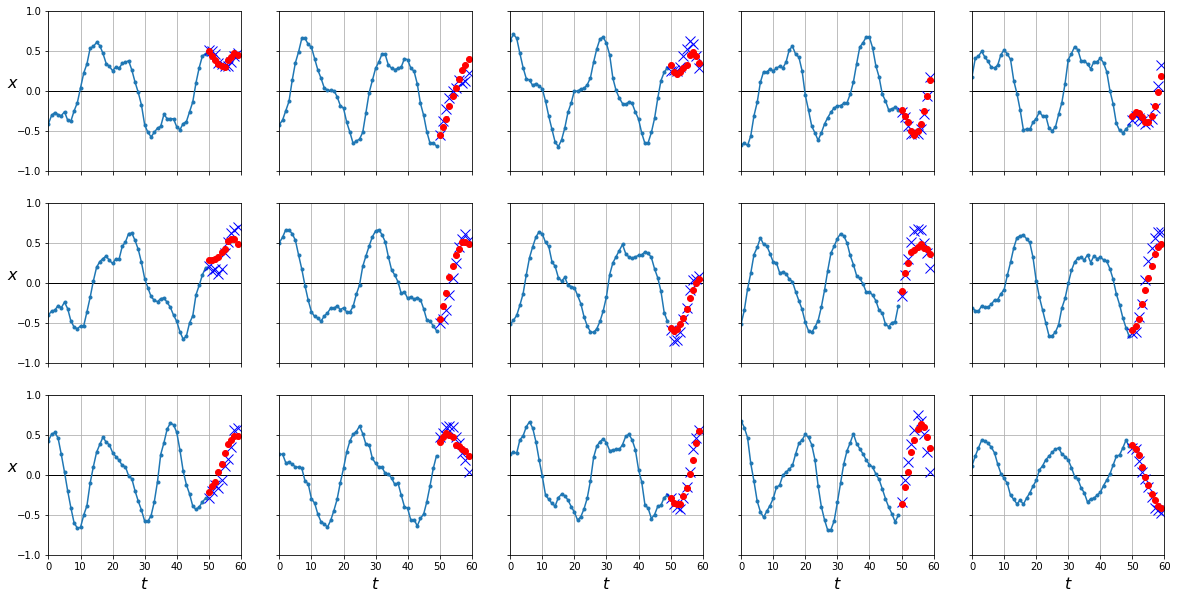

y_test shape:
(1000, 10, 1)
y_pred shape:
torch.Size([1000, 10])
Error cuadratico medio de la estimación final: 


0.014071524

In [153]:
y_pred = predict(rnn_deep2, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())

y_testb = np.squeeze(y_test)
print('y_test shape:')
print(y_test.shape)
print('y_pred shape:')
print(y_pred.shape)
print('Error cuadratico medio de la estimación final: ')
mean_squared_error(np.squeeze(y_test), np.squeeze(y_pred))

Conclusiones:


1. Se incrementa a 25 el numero de hidden layers.
2. Se incrmenta a 4 el numero de layers.
3. El fully connected se ajusta para que tenga 10 salidas( las 10 muestras del futuro)

